<a href="https://colab.research.google.com/github/adamskiij99/activation_sparsity/blob/master/Copy_of_TODL_PS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
from tqdm import tqdm

# 2) Histogram of pre and post activation values

In [132]:
# Get and normalize a sample batch of mnist data to work with

(x_train, y_train), (x_test, y_test)= mnist.load_data()
batch_size = 256
x = x_train[:batch_size, :, :]/255
y = y_train[:batch_size]/255

#function to  build feed a fordward net
def get_model(widths=[28**2], sigma_w = 1, sigma_b = 0,
              normalize = True, activation='tanh'):
  model = Sequential([Flatten()])
  for i, N in enumerate(widths[1:]):
    if normalize:  
      kernel_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_w/np.sqrt(widths[i-1]+N))
    else:
      kernel_initialiser = tf.random_normal_initializer(mean=0, stddev = sigma_w)
    bias_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_b)
    model.add(Dense(N, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser))
    model.add(Activation(activation))

  return model

In [133]:
def get_activations(x, widths, sigma_w, sigma_b, normalize, activation):
  # build new instance of model (i.e. new weights and biases)
  model = get_model(widths=widths , normalize=normalize, sigma_w=sigma_w, sigma_b=sigma_b, activation=activation)
  model.build((None, 28,28))
  # build function to collect pre-activation layers when an input is passed into the net
  inp = model.input
  out = [layer.output for layer in model.layers if isinstance(layer, Dense)]
  get_lay_outputs = K.function(inp, out)

  # Pass input  through the net to get layer outputs 
  pre_activation_layers = get_lay_outputs(x)

  # build function to collect post-activation layers when an input is passed into the net
  inp = model.input
  out = [layer.output for layer in model.layers if isinstance(layer, Activation)]
  get_lay_outputs = K.function(inp, out)
  
  # Pass input  through the net to get layer outputs
  post_activation_layers = get_lay_outputs(x)
  
  #avoid memory problems by deleting model and clearing session
  del model
  tf.keras.backend.clear_session()
  return pre_activation_layers, post_activation_layers


In [138]:
#Experiment with these parameters

widths = [28**2] + [28**2 for _ in range(6)] # [input dim] + [layer_wdths]
normalize = True
sigma_w = 1.77
sigma_b = 1.41

tau = 0.0001 # Must be >0

def soft_thresholding(x):
  return K.relu(x - tau) - K.relu(-x - tau)
get_custom_objects().update({'custom_activation': Activation(soft_thresholding)})

activation='custom_activation'

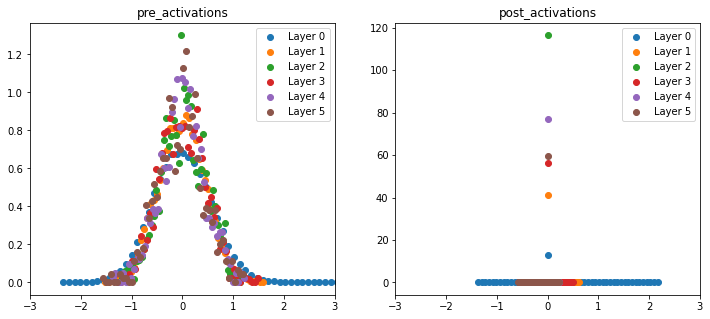

In [142]:
#1.3174440296741532 
#0.4306108153269152

sigma_w = 1.62
sigma_b = 0.43
tau = 1 # Must be >0

pre_activation_layers, post_activation_layers = get_activations(x, widths, sigma_w, sigma_b, normalize, activation)

fig, axs = plt.subplots(1,2, figsize=(12,5))
for i, activations in enumerate(pre_activation_layers):
  h, b = np.histogram(activations, bins=50, density=True)
  b = [(b[i+1]+b[i])/2 for i in range(len(b)-1) ]
  axs[0].scatter(b,h, label = f"Layer {i}")
axs[0].set_title("pre_activations")
axs[0].set_xlim([-3, 3])
axs[0].legend()

for i, activations in enumerate(post_activation_layers):
  h, b = np.histogram(activations, bins=50, density=True)
  b = [(b[i+1]+b[i])/2 for i in range(len(b)-1) ]
  axs[1].scatter(b,h, label = f"Layer {i}")
axs[1].set_title("post_activations")
axs[1].set_xlim([-3, 3])
axs[1].legend()

##3a) Calculating q*

First, lets calculate $q^*$ by iteratively solving for $q^l$, using equation (3) from the paper by Poole et al.

[1.01735079 6.44844242 4.48737047 4.16892765 4.09984038 4.08395427
 4.08025296 4.07938795 4.07918564 4.07913832]


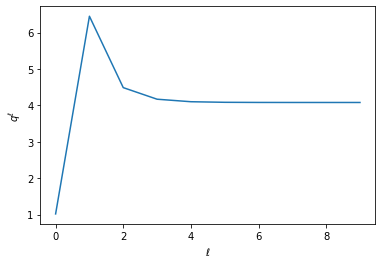

In [144]:
def normal(z):
  return (1/np.sqrt(2*np.pi))*np.exp(-(z**2)/2)

def integrand(z,q):
  return normal(z)*(np.tanh(np.sqrt(q)*z)**2)



N = 1000 #layer width
x = np.random.normal(size=N)

#use initial condition given in the paper
q0 = (1/len(x))*np.dot(x,x)
sw = 2.5
sb= 0.3
q1 = (sw**2)*q0 + sb**2 

qs = []
qs.append(q0)
qs.append(q1)


#iterate to convergence within specified tolerance
count = 0
while np.abs(qs[count+1]-qs[count])>1e-04:
  q1,_ = sp.integrate.quad(lambda z: integrand(z,q1), -np.inf, np.inf)
  q1 = (sw**2)*q1 + sb**2
  qs.append(q1)
  count+=1

# Display and plot the results
plt.plot(qs)
plt.xlabel('$\ell$')
plt.ylabel('$q^\ell$')
print(np.array(qs))


## 3b) Empirically observed q*

Next, lets design a feedforward networks, and calculate the length of each layer, averaged of the weights and biases



In [165]:
#function to  build feed fordward soft_thr net
def get_model(num_layers, width = N, sigma_w = 2.5, sigma_b = 0.3):  
  model = Sequential()
  kernel_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_w/np.sqrt(N))
  bias_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_b)
  for i in range(num_layers):
    a = Dense(width, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser)
    model.add(a)
    model.add(Activation('custom_activation'))

  return model

In [146]:
x = np.random.normal(size=(1,N))

num_layers = 7
num_samples = 100

average_layer_norms = np.zeros(num_layers)
for i in range(num_samples):
  # build new instance of model (i.e. new weights and biases)
  model = get_model(num_layers, width=N)
  model.build((None, N))
  
  # build function to collect pre-activation layers when an input is passed into the net
  inp = model.input
  out = [layer.output for layer in model.layers if isinstance(layer, Dense)]
  get_lay_outputs = K.function(inp, out)

  # Pass input  through the net to get layer outputs 
  pre_activation_layers = get_lay_outputs(x)

  # calculate squared 2-norm of each pre-activation layer
  for l, lay in enumerate(pre_activation_layers):
    h = lay[0,:]
    average_layer_norms[l]+=(np.linalg.norm(h,2)**2)/N
  
  #avoid memory problems by deleting model and clearing session
  del model
  tf.keras.backend.clear_session()

average_layer_norms=np.divide(average_layer_norms, num_samples)
average_layer_norms

array([6.17293835e+00, 1.94477292e+01, 8.40834794e+01, 4.43020507e+02,
       2.57456371e+03, 1.55139767e+04, 9.54588810e+04])

## 3c) Computing the edge of chaos curve

Here,  we simply use what you proved in questiton 3, to calculate $\sigma_w$ from $q^*$, and the equation (3) - used above - to calculate $\sigma_b$ from $\sigma_w$ and $q^*$


In [147]:
def d_tanh(z):
  return np.subtract(1, np.square(np.tanh(z)))

def d_soft(z):
  if np.abs(z) < tau:
    return 0
  else:
    return 1

def chi_1_integrand(z, qstar):
  return normal(z)*(d_soft(np.sqrt(qstar)*z))**2
  
def calc_sw(qstar):
  integral, _ = sp.integrate.quad(lambda z: chi_1_integrand(z,qstar), -np.inf, np.inf)
  return np.sqrt(np.divide(1,integral))

def calc_sb(qstar, sw):
  integral,_ = sp.integrate.quad(lambda z: integrand(z,qstar), -np.inf, np.inf)
  return np.sqrt(qstar - (sw**2)*integral)

In [148]:
sigma_ws = []
sigma_bs = []
for qstar in tqdm(np.linspace(0.1, 20, 500)):
  sw = calc_sw(qstar)
  sb = calc_sb(qstar, sw)
  sigma_ws.append(sw)
  sigma_bs.append(sb)

 19%|█▉        | 95/500 [00:01<00:06, 62.67it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
100%|██████████| 500/500 [00:08<00:00, 61.49it/s]


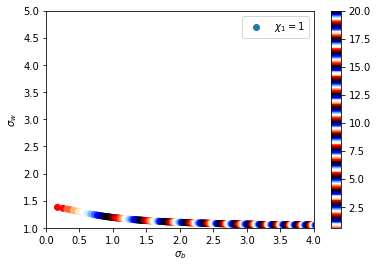

In [119]:
#recreating the plot of the edge of chaos from Figure integral2c in the Poole et al. paper
plt.scatter(sigma_bs, sigma_ws, label = '$\chi_1 = 1$', c = np.linspace(0.1, 20, 500), cmap = "flag")
plt.colorbar()
plt.xlim([0,4])
plt.ylim([1,5])
plt.xlabel('$\sigma_b$')
plt.ylabel('$\sigma_w$')
plt.legend()

In [156]:
qstar = 2.1
sw = calc_sw(qstar)
sb = calc_sb(qstar, sw)
print(sw, "\n", sb)

1.4283485060074343 
 1.0107419706133214


##3d) Correlation with depth

In this question, we will pass 2 inputs through our feedforward net, and check their correlations $c_{12}$ at each  layer. Vary the values of $\sigma_w$ and $\sigma_b$ and see what happens. Note that one type of behaviour is easier to see when starting with correlated inputs, and the other is more easily visible when starting with uncorrelated inputs - hence the different initialisations of $x_2$

vary these $\sigma_w$; for $\sigma_w =1.3$ for $\sigma_b =0.3$ is in the ORDERED regime, $\sigma_w=2.5$ and larger is in the CHAOTIC regime for $\sigma_b=0.3$.

In the ordered regime our correlation coefficient converges to 1, since because $c^*=1$ is a stable fixed point $(\chi_1<1)$

In the CHAOTIC regime, our correlation coefficient converges to some other fixed point which is now stable: $\bar{c}\in[0,1)$. The fixed point $c^*=1$ is unstable because $\chi_1>1$ (see Fig 2-A in paper). 

This means that the points decorelate, at least to some extent. For $\sigma_b=0$, the convergence is towards $\bar{c}=0$, so the points perfectly decorrelate at infinity (the angle between them becomes 90 degrees in the limit). For any $\sigma_b>0$ we get transient chaos. 


In [181]:
N = 1000

x1 = np.random.normal(size=(1,N))
x2_sim = 3*x1.copy()
x2 = np.random.normal(size=(1,N))


num_samples = 20
num_layers = 25

#vary these
"""
sigma_w1 = 1.3
sigma_w2 = 1.33
sigma_w3 = 1.66
sigma_w4 = 1.4
sigma_w5 = 1.428
sigma_w6 = 1.429
"""
sigma_b = 1.0107

sigma_w1,sigma_w2,sigma_w3,sigma_w4,sigma_w5,sigma_w6 = np.linspace(1, 1.6, 6)

average_layer_corrs1 = np.zeros(num_layers)
average_layer_corrs2 = np.zeros(num_layers)
average_layer_corrs3 = np.zeros(num_layers)
average_layer_corrs4 = np.zeros(num_layers)
average_layer_corrs5 = np.zeros(num_layers)
average_layer_corrs6 = np.zeros(num_layers)

for i in tqdm(range(num_samples)):
  model1 = get_model(num_layers, sigma_w = sigma_w1, sigma_b = sigma_b,width=N)
  model1.build((None, N))
  model2 = get_model(num_layers, sigma_w = sigma_w2, sigma_b = sigma_b,width=N)
  model2.build((None, N))
  model3 = get_model(num_layers, sigma_w = sigma_w3, sigma_b = sigma_b,width=N)
  model3.build((None, N))
  model4 = get_model(num_layers, sigma_w = sigma_w4, sigma_b = sigma_b,width=N)
  model4.build((None, N))
  model5 = get_model(num_layers, sigma_w = sigma_w5, sigma_b = sigma_b,width=N)
  model5.build((None, N))
  model6 = get_model(num_layers, sigma_w = sigma_w6, sigma_b = sigma_b,width=N)
  model6.build((None, N))
  
  inp1 = model1.input
  out1 = [layer.output for layer in model1.layers if isinstance(layer, Dense)]
  get_lay_outputs1 = K.function(inp1, out1)
  pre_activation_layers11 = get_lay_outputs1(x1)
  pre_activation_layers12 = get_lay_outputs1(x2_sim)
  
  for l in range(len(pre_activation_layers11)):
    h11 = pre_activation_layers11[l][0,:]
    h12 = pre_activation_layers12[l][0,:]
    average_layer_corrs1[l]+= np.corrcoef(h11, h12)[0,1]

  inp2 = model2.input
  out2 = [layer.output for layer in model2.layers if isinstance(layer, Dense)]
  get_lay_outputs2 = K.function(inp2, out2)
  pre_activation_layers21 = get_lay_outputs2(x1)
  pre_activation_layers22 = get_lay_outputs2(x2_sim)


  for l in range(len(pre_activation_layers21)):
    h21 = pre_activation_layers21[l][0,:]
    h22 = pre_activation_layers22[l][0,:]
    average_layer_corrs2[l]+= np.corrcoef(h21, h22)[0,1]

  inp3 = model3.input
  out3 = [layer.output for layer in model3.layers if isinstance(layer, Dense)]
  get_lay_outputs3 = K.function(inp3, out3)
  pre_activation_layers31 = get_lay_outputs3(x1)
  pre_activation_layers32 = get_lay_outputs3(x2_sim)


  for l in range(len(pre_activation_layers31)):
    h31 = pre_activation_layers31[l][0,:]
    h32 = pre_activation_layers32[l][0,:]
    average_layer_corrs3[l]+= np.corrcoef(h31, h32)[0,1]

  inp4 = model4.input
  out4 = [layer.output for layer in model4.layers if isinstance(layer, Dense)]
  get_lay_outputs4 = K.function(inp4, out4)
  pre_activation_layers41 = get_lay_outputs4(x1)
  pre_activation_layers42 = get_lay_outputs4(x2_sim)


  for l in range(len(pre_activation_layers41)):
    h41 = pre_activation_layers41[l][0,:]
    h42 = pre_activation_layers42[l][0,:]
    average_layer_corrs4[l]+= np.corrcoef(h41, h42)[0,1]

  inp5 = model5.input
  out5 = [layer.output for layer in model5.layers if isinstance(layer, Dense)]
  get_lay_outputs5 = K.function(inp5, out5)
  pre_activation_layers51 = get_lay_outputs5(x1)
  pre_activation_layers52 = get_lay_outputs5(x2_sim)


  for l in range(len(pre_activation_layers51)):
    h51 = pre_activation_layers51[l][0,:]
    h52 = pre_activation_layers52[l][0,:]
    average_layer_corrs5[l]+= np.corrcoef(h51, h52)[0,1]

  inp6 = model6.input
  out6 = [layer.output for layer in model6.layers if isinstance(layer, Dense)]
  get_lay_outputs6 = K.function(inp6, out6)
  pre_activation_layers61 = get_lay_outputs6(x1)
  pre_activation_layers62 = get_lay_outputs6(x2_sim)

  for l in range(len(pre_activation_layers61)):
    h61 = pre_activation_layers61[l][0,:]
    h62 = pre_activation_layers62[l][0,:]
    average_layer_corrs6[l]+= np.corrcoef(h61, h62)[0,1]


  del model1, model2, model3, model4, model5, model6
  tf.keras.backend.clear_session()

average_layer_corrs1=np.divide(average_layer_corrs1, num_samples)
average_layer_corrs2=np.divide(average_layer_corrs2, num_samples)
average_layer_corrs3=np.divide(average_layer_corrs3, num_samples)
average_layer_corrs4=np.divide(average_layer_corrs4, num_samples)
average_layer_corrs5=np.divide(average_layer_corrs5, num_samples)
average_layer_corrs6=np.divide(average_layer_corrs6, num_samples)

100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


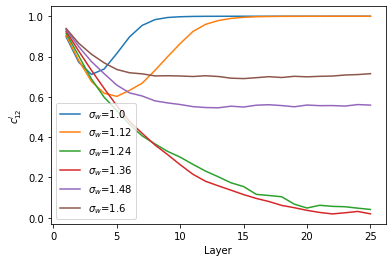

In [182]:
plt.plot(np.arange(num_layers)+1, average_layer_corrs1)
plt.plot(np.arange(num_layers)+1, average_layer_corrs2)
plt.plot(np.arange(num_layers)+1, average_layer_corrs3)
plt.plot(np.arange(num_layers)+1, average_layer_corrs4)
plt.plot(np.arange(num_layers)+1, average_layer_corrs5)
plt.plot(np.arange(num_layers)+1, average_layer_corrs6)
plt.xlabel('Layer')
plt.ylabel('$c_{12}^l$')
plt.legend((f'$\sigma_w$={sigma_w1}', 
            f'$\sigma_w$={sigma_w2}', 
            f'$\sigma_w$={sigma_w3}', 
            f'$\sigma_w$={sigma_w4}', 
            f'$\sigma_w$={sigma_w5}', 
            f'$\sigma_w$={sigma_w6}'))

##5) Gradient magnitude through depth

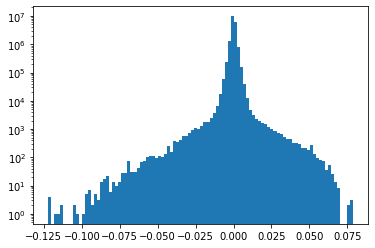

In [ ]:
# For this question we will need a loss function, and so we will need data with labels. We may as well use MNIST - though synthetic data would do just fine.

 # Sample batch of MNIST data
(x_train, y_train), (x_test, y_test)= mnist.load_data()
batch_size = 128
x_batch = x_train[:batch_size, :, :]
y_batch = y_train[:batch_size]

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# functions to compute loss and gradients

def loss(model, x, y, training):
  y_hat = model(x)
  return loss_object(y_true=y, y_pred=y_hat)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


# Function to build model

def get_model(num_layers, width = N, sigma_w = 2.5, sigma_b = 0.3):  
  model = Sequential()
  model.add(Flatten())
  kernel_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_w/np.sqrt(N))
  bias_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_b)
  for i in range(num_layers):
    model.add(Dense(width, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser))
    model.add(Activation('tanh'))
  model.add(Dense(10, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser))
  return model

# Now we build a deep net, and vary 𝜎𝑤 and 𝜎𝑏 and examine the impact on the gradients

num_layers = 30
#vary these
sigma_w = 1.3
sigma_b = 0.3
N = 28*28

model = get_model(num_layers, sigma_w = sigma_w, sigma_b = sigma_b,width=N)
loss_value,  grads = grad(model, x_batch, y_batch)

# plt.plot(np.concatenate([tf.reshape(g, -1) for g in grads]))

plt.hist(np.concatenate([tf.reshape(g, -1) for g in grads]), bins = 100, log=True);
 

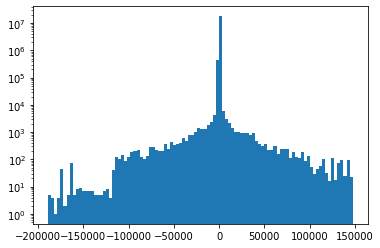

In [ ]:
num_layers = 30
#vary these
sigma_w = 4
sigma_b = 0.3
N = 28*28

model = get_model(num_layers, sigma_w = sigma_w, sigma_b = sigma_b,width=N)
loss_value,  grads = grad(model, x_batch, y_batch)


plt.hist(np.concatenate([tf.reshape(g, -1) for g in grads]), bins = 100, log=True);
 